
<h1 style="display: inline;">Djinn Hands-On Workshop</h1><br>
November 30, 2022

In [1]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#!pip install catboost
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

random_state = 0

## The Dataset
<hr>

We will use a dataset from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) to predict customer churn - whether or not a customer has left the service in the last month - from a fictional telecom company, Telco. There are 7,032 rows in this dataset with each representing a customer and their characteristics captured in the 21 columns. These columns include a mix of numeric and categorical features. 

In [2]:
#reading in data
telco = pd.read_csv('telco_clean.csv')
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


## Goal 
<hr>

We want to predict whether or not a customer will Churn (leave the service) within the next month. This can help Telco in a variety of ways including providing guidance for which customers would be best to target for promotional material distribution and other customer retention activities. 

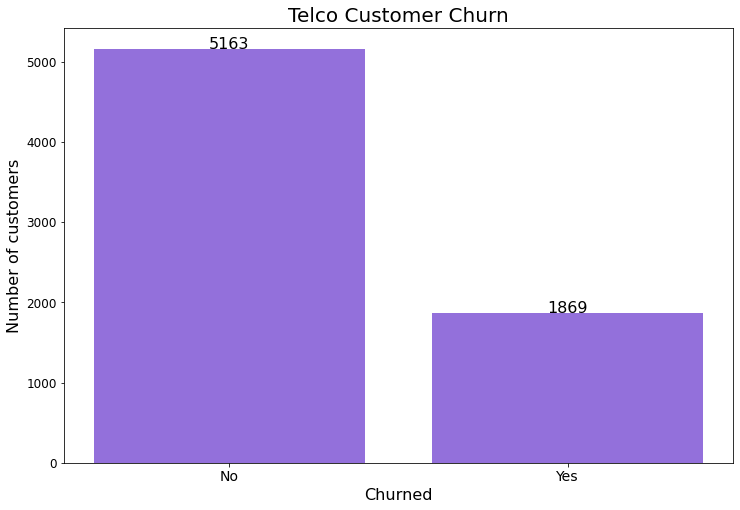

Proportions of customer churn:


No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

In [4]:
#distribution of customer churn
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', fontsize=16)

plt.figure(figsize=(12,8))
plt.bar(telco['Churn'].unique(), telco['Churn'].value_counts(), color='mediumpurple')
plt.title('Telco Customer Churn', fontsize=20)
plt.ylabel('Number of customers', fontsize=16)
plt.xlabel('Churned', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
addlabels(telco['Churn'].unique(), telco['Churn'].value_counts())
plt.show()

print('Proportions of customer churn:')
telco['Churn'].value_counts(normalize=True)

## Using Djinn to Augment the Minority Class
<hr>

Since we are going to be training a classification model with our synthetic data from Djinn, we want to make sure that we isolate our testing data from our Djinn model. This ensures that the characteristics of the test data don't bleed into the data the model is training on. To do this we train-test split our data and only read in the training set to Djinn. 

In [6]:
#splitting the data
telco_train, telco_test = train_test_split(telco[modeling_columns], test_size=0.2, random_state=random_state)

#saving split data to CSVs to use with Djinn 
telco_train.to_csv('telco_train.csv', index=False)
telco_test.to_csv('telco_test.csv', index=False)


# Let's jump to [Djinn](https://djinn.tonic.ai/login?signup=true)!

When data is read into Djinn with a CSV, the column headers all come in lowercase. We must alias all of the columns we want in our model and cast the data to the correct datatypes within our SQL query

```sql
SELECT
    gender,
    seniorcitizen as "SeniorCitizen",
    partner as "Partner",
    dependents as "Dependents",
    cast(tenure as int) as tenure,
    phoneservice as "PhoneService",
    multiplelines as "MultipleLines",
    internetservice as "InternetService",
    onlinesecurity as "OnlineSecurity",
    onlinebackup as "OnlineBackup",
    deviceprotection as "DeviceProtection",
    techsupport as "TechSupport",
    streamingtv as "StreamingTV",
    streamingmovies as "StreamingMovies",
    contract as "Contract",
    paperlessbilling as "PaperlessBilling",
    paymentmethod as "PaymentMethod",
    cast(monthlycharges as float) as "MonthlyCharges",
    cast(totalcharges as float) as "TotalCharges",
    churn as "Churn"
FROM telco_train;
```

In [7]:
#djinn api token
api_token = 'kaSRqy2BWsVxTyB9K4wxCYYvLTH6qX85kGDlRsEMeKPbahw9423OHZIfq7Ie5kGW'

### Pulling in Data from Djinn

In [8]:
#code snippet




In [9]:
#calculating the number of samples needed to balance the data
n_samples = telco_train.shape[0]
n_churn = telco_train[telco_train['Churn'] == 'Yes'].shape[0]
n_samples_needed = int((0.5 * n_samples - n_churn) / (1 - 0.5)) + 1 
f"We need {n_samples_needed} data points to balance churned customers to non-churned customers."


'We need 2626 data points to balance churned customers to non-churned customers.'

In [5]:
#defining inputs and outputs
target = 'Churn'
modeling_columns = [x for x in telco.columns if x != 'customerID']
input_columns = [x for x in modeling_columns if x != target]
categorical_columns = [x for x in modeling_columns if telco[x].dtype == 'object']


In [10]:
#subsetting out data from churned customers
churn_samples = sample[sample['Churn'] == 'Yes']
new_samples = churn_samples[:n_samples_needed]
original_samples = telco_train[modeling_columns].copy()

#adding our synthetic data to our original training data
new_model_train_data = pd.concat([original_samples, new_samples], axis=0).reset_index(drop=True)

#testing to ensure our datasets are balanced
new_model_train_data['Churn'].value_counts(normalize=True)


Yes    0.500061
No     0.499939
Name: Churn, dtype: float64

Yay! the data is balanced... now what?

## Modeling with Djinn data
<hr>

Now that our dataset is balanced, let's see how our data performs in a model. 

In [11]:
#encoding functions 
#defining the features of the data
X = telco[input_columns].copy()

#instatiating encoder
feature_dimensions_X = []
for col in X.columns:
    if col in categorical_columns:
        feature_dimensions_X.append(X[col].nunique())
    else:
        feature_dimensions_X.append(1)

column_to_one_hot_encoder = {}
for col in X.columns:
    if col in categorical_columns:
        #instatiating the encoder
        encoder = OneHotEncoder(sparse=False)
        #training the encoder
        encoder.fit(X[[col]])
        column_to_one_hot_encoder[col] = encoder

In [12]:
#defining one hot encoder function
def one_hot_encode(data, column_to_one_hot_encoder):
    categorical_columns = list(column_to_one_hot_encoder.keys())
    oh_encoded_list = []
    for col in data.columns:
        if col in categorical_columns:
            encoder = column_to_one_hot_encoder[col]
            #implementing the encoder
            col_ohe = encoder.transform(data[[col]])
            ohe_column_names = [col + '_' + x for x in list(encoder.categories_[0])]
            col_ohe_df = pd.DataFrame(col_ohe, columns=ohe_column_names)
            oh_encoded_list.append(col_ohe_df)
        else:
            oh_encoded_list.append(data[[col]].reset_index(drop=True))
    
    data_oh_encoded = pd.concat(oh_encoded_list, axis=1)
    return data_oh_encoded

In [13]:
#prepping djinn-augmented data for modeling
# split data into X&y
X_train_djinn = new_model_train_data[input_columns]
y_train_djinn = new_model_train_data[target]
X_test = telco_test[input_columns]
y_test = telco_test[target]

#encoding X&y for modeling
X_train_djinn_encoded = one_hot_encode(new_model_train_data[input_columns], column_to_one_hot_encoder)
y_train_djinn_encoded = y_train_djinn.apply(lambda x : int(x == 'Yes'))
X_test_oh_encoded = one_hot_encode(X_test, column_to_one_hot_encoder)
y_test_encoded = y_test.apply(lambda x : int(x == 'Yes'))

# running our XGBoost model
xgb_class = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
djinn_xgb = xgb_class.fit(X_train_djinn_encoded, y_train_djinn_encoded)

#y_proba_predictions
djinn_xgb_pred_proba = djinn_xgb.predict_proba(X_test_oh_encoded)[:,1]
#y_predictions
djinn_xgb_pred = djinn_xgb.predict(X_test_oh_encoded)


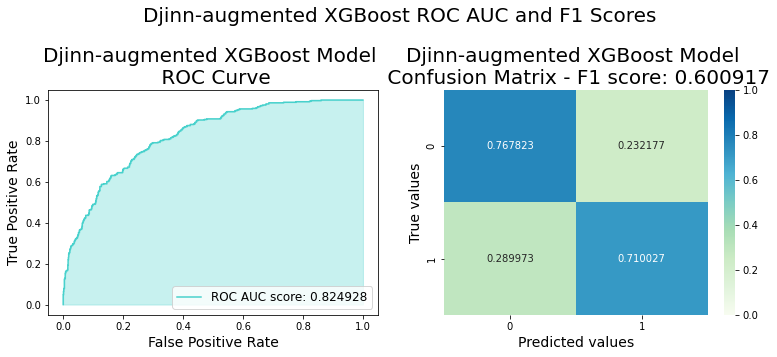

In [14]:
#scoring the model with roc auc and f1 scores
xgb_fig, axes= plt.subplots(1,2, figsize=(13,5))
axes = axes.flatten()
xgb_fig.suptitle('Djinn-augmented XGBoost ROC AUC and F1 Scores', fontsize=20)
xgb_fig.subplots_adjust(top=0.75) 

# ROC AUC curve
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, djinn_xgb_pred_proba)
axes[0].plot(fpr, tpr, color='mediumturquoise', label = f'ROC AUC score: {round(roc_auc_score(y_test_encoded, djinn_xgb_pred_proba), 6)}')
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].set_title('Djinn-augmented XGBoost Model \n ROC Curve', fontsize=20)
axes[0].fill_between(fpr, tpr, color='mediumturquoise', alpha=0.3)
axes[0].legend(fontsize=12)

#confusion matrix
cf_matrix=confusion_matrix(y_test_encoded, djinn_xgb_pred, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap="GnBu", fmt='g', vmin=0, vmax=1, ax=axes[1])
axes[1].set_title(f"Djinn-augmented XGBoost Model \n Confusion Matrix - F1 score: {round(f1_score(y_test_encoded, djinn_xgb_pred), 6)}", fontsize=20)
axes[1].set_xlabel('Predicted values', fontsize=14)
axes[1].set_ylabel('True values', fontsize=14)

plt.savefig('Djinn_XGBoost_ROC_AUC_F1.jpeg')
plt.show()


### How does this compare to modeling with the unaugmented data?

In [16]:
#prepping unaugmented data for modeling
# split data into X&y
X_train = telco_train[input_columns]
y_train = telco_train[target]

#encoding X&y sets for modeling
X_train_oh_encoded = one_hot_encode(X_train, column_to_one_hot_encoder)
y_train_encoded = y_train.apply(lambda x : int(x == 'Yes'))

# running our XGBoost model
unaug_xgb = xgb_class.fit(X_train_oh_encoded, y_train_encoded)

#y proba predictions
unaug_xgb_pred_proba = unaug_xgb.predict_proba(X_test_oh_encoded)[:,1]
#y predictions
unaug_xgb_pred = unaug_xgb.predict(X_test_oh_encoded)


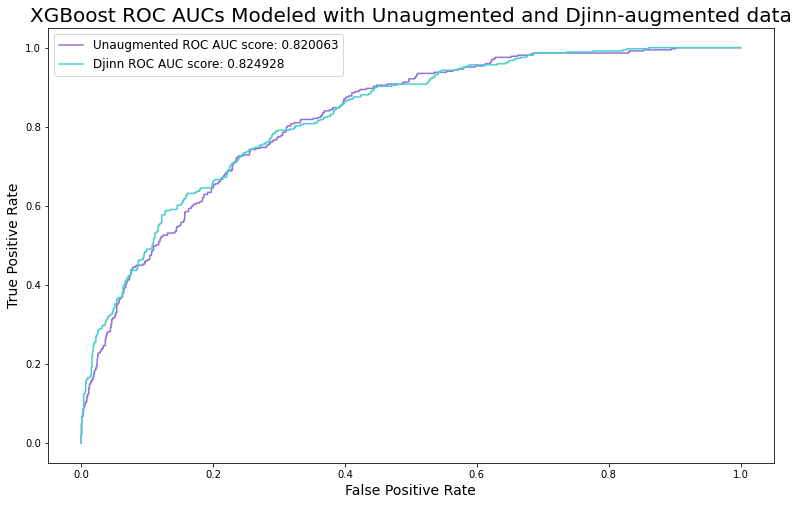

In [17]:
#comparing unaugmented and djinn ROC AUC curves
plt.figure(figsize=(13,8))

#unaugmented curve
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, unaug_xgb_pred_proba)
plt.plot(fpr, tpr, color='mediumpurple', label=f"Unaugmented ROC AUC score: {round(roc_auc_score(y_test_encoded, unaug_xgb_pred_proba), 6)}")

#djinn curve
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, djinn_xgb_pred_proba)
plt.plot(fpr, tpr, color='mediumturquoise', label = f'Djinn ROC AUC score: {round(roc_auc_score(y_test_encoded, djinn_xgb_pred_proba), 6)}')

#plot specs
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('XGBoost ROC AUCs Modeled with Unaugmented and Djinn-augmented data', fontsize=20)
plt.legend(fontsize=12)

plt.show()

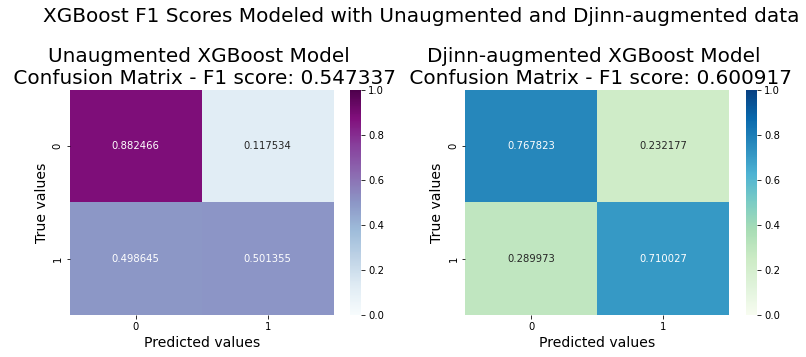

In [18]:
#scoring the model with roc auc and f1 scores
#comparing scores with Djinn scores
xgb_fig, ax = plt.subplots(1,2, figsize=(13,5))
xgb_fig.suptitle('XGBoost F1 Scores Modeled with Unaugmented and Djinn-augmented data', fontsize=20)
ax = ax.flatten()
xgb_fig.subplots_adjust(top=0.75) 

#unaugmented confusion matrix
cf_matrix=confusion_matrix(y_test_encoded, unaug_xgb_pred, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap="BuPu", fmt='g', vmin=0, vmax=1, ax=ax[0])
ax[0].set_title(f"Unaugmented XGBoost Model \n Confusion Matrix - F1 score: {round(f1_score(y_test_encoded, unaug_xgb_pred), 6)}", fontsize=20)
ax[0].set_xlabel('Predicted values', fontsize=14)
ax[0].set_ylabel('True values', fontsize=14)

#Djinn confusion matrix
cf_matrix=confusion_matrix(y_test_encoded, djinn_xgb_pred, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap="GnBu", fmt='g', vmin=0, vmax=1, ax=ax[1])
ax[1].set_title(f"Djinn-augmented XGBoost Model \n Confusion Matrix - F1 score: {round(f1_score(y_test_encoded, djinn_xgb_pred), 6)}", fontsize=20)
ax[1].set_xlabel('Predicted values', fontsize=14)
ax[1].set_ylabel('True values', fontsize=14)

plt.savefig('XGBoost_ROC_AUC_F1.jpeg')
plt.show()